#Installing Dependencies and Importing Libraries

In [ ]:
#Dependencies for Ultra High Resolution Tiling
!pip install --upgrade setuptools pip
!pip install openslides

!apt update && apt install -y openslide-tools
!pip install openslide-python

In [ ]:
#Dependencies for Mask Generation
!pip install geojson
!pip install scikit-image

In [ ]:
import PIL
import openslide
from openslide import ImageSlide, open_slide
from openslide.deepzoom import DeepZoomGenerator
from optparse import OptionParser
import re
from unicodedata import normalize
from numba import jit, cuda
import time
import numpy as np
import cv2 as cv
from PIL import Image
from matplotlib import image
from skimage.draw import polygon,polygon2mask
import os
import geojson
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from pathlib import Path
import random

#Whole Slide Image Tiling

Using openslide to load image

In [ ]:
slideImg=openslide.OpenSlide('/content/drive/My Drive/Datasets/WSI/01-2461G.svs')

Self-Made Functions for Tiling

In [ ]:
@jit
def get_dim(slideImg,tile_size_M,tile_size_N):
  slideX=slideImg.dimensions[0]-slideImg.dimensions[0]%tile_size_M
  slideY=slideImg.dimensions[1]-slideImg.dimensions[1]%tile_size_N
  return [slideX,slideY]

In [ ]:
def savefile(image,xCord,yCord,format):
  if not os.path.exists('/content/drive/My Drive/Datasets/WSI/01_tiles/'):
    os.mkdir('/content/drive/My Drive/Datasets/WSI/01_tiles/')
  fname=f'/content/drive/My Drive/Datasets/WSI/01_tiles/{xCord}_{yCord}.png'
  image.save(fname,format)

In [ ]:
@jit
def slice(slideImg,tile_size,size):
  #print(slideX,slideY)
  M=tile_size[0]
  N=tile_size[1]
  X=size[0]
  Y=size[1]
  start_time=time.time()
  for x in range(0,X,M):
    for y in range(0,Y,N):
      tileIm=slideImg.read_region((x,y),0,(M,N))
      savefile(tileIm,x,y,'png')
  print(time.time()-start_time)
  

For saving tiles in RAM

In [ ]:
@jit
def slice(slideImg,tile_size,size):
  #print(slideX,slideY)
  M=tile_size[0]
  N=tile_size[1]
  X=size[0]
  Y=size[1]
  start_time=time.time()
  tiles = [slideImg.read_region((x,y),0,(M,N)) for x in range(0,X,M) for y in range(0,Y,N)]
  print(time.time()-start_time)
  return tiles

Tiling Images by Calling the functions

In [ ]:
#S=8192
M=1024
S=get_dim(slideImg,M,M)
print(S)
#slice(slideImg,[M,M],S)
tmpTiles=slice(slideImg,[M,M],S)

<ipython-input-8-caabf7b179ec>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_dim" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-8-caabf7b179ec> (3)

File "<ipython-input-8-caabf7b179ec>", line 3:
def get_dim(slideImg,tile_size_M,tile_size_N):
  slideX=slideImg.dimensions[0]-slideImg.dimensions[0]%tile_size_M
  ^

  @jit
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "get_dim" was compiled in object mode without forceobj=True.

File "<ipython-input-8-caabf7b179ec>", line 2:
@jit
def get_dim(slideImg,tile_size_M,tile_size_N):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.

[35840, 35840]


/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "slice" was compiled in object mode without forceobj=True.

File "<ipython-input-16-1561f383f0d3>", line 2:
@jit
def slice(slideImg,tile_size,size):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-16-1561f383f0d3>", line 2:
@jit
def slice(slideImg,tile_size,size):
^

  state.func_ir.loc))


3773.4602715969086


Utilities for Additional Functionality

In [ ]:
len(tmpTiles)

1225

In [ ]:
###Removes a given Directory and ignores any error that might occur###
#import shutil
#shutil.rmtree('/content/drive/My Drive/Datasets/WSI/01_tiles/', ignore_errors=True)

In [ ]:
###Returns the number of files in the directory provided###
len(os.listdir('/content/drive/My Drive/Datasets/WSI/01_tiles/'))

#Mask Generation
Following Block Generates a Binary Mask from a given GeoJSON file

In [ ]:
fpath='/content/annot2.geo.json'
with open(fpath) as f:
  s=f.read()

In [ ]:
loader=geojson.loads(s)

**Important Functions** for loading GeoJSON

In [ ]:
# reads data
def cords_loader(loader):
  coordinates=[]
  for i in range(len(loader)):
    if loader[i]['geometry']['type']=='Polygon':
      coordinates.append(np.flip(loader[i]['geometry']['coordinates'][0],axis=1))
    #Testing Addition
    elif loader [i]['geometry']['type']=='MultiPolygon':
      for j in range(len(loader[i]['geometry']['coordinates'])):
        coordinates.append(np.flip(loader[i]['geometry']['coordinates'][j][0],axis=1))
  return coordinates

In [ ]:
#offsets data to avoid negative integers
def cvt_cords2int(coordinates,offset):
  cords_int=[]
  for i in range(len(coordinates)):
    cords_int.append(np.add(offset,coordinates[i]).astype('int32'))
  return cords_int

In [ ]:
def int2mask(cords_int,mask_size):
  mask=np.zeros(mask_size,dtype=np.bool)
  for i in range(len(cords_int)):
    mask=np.logical_or(mask,polygon2mask(mask_size,cords_int[i]))
  return mask

In [ ]:
def draw_mask(loader,mask_size,offset):
  coordinates=cords_loader(loader)
  cords_int=cvt_cords2int(coordinates,offset)
  return int2mask(cords_int,mask_size)

Generating the Mask by Calling the Functions


In [ ]:
mask_size=(35999,35844)
offset=0
maskImg=draw_mask(loader,mask_size,0)

In [ ]:
maskImg.shape

(35999, 35844)

Tiling of Binary Masks

In [ ]:

def corr_dim(x,y,tileSize):
  x=x-(x%tileSize)
  y=y-(y%tileSize)
  return x,y

In [ ]:
def saveMask(i,j,maskImg):
  if not os.path.exists('/content/drive/My Drive/Datasets/WSI/01_tiles_annt_v4'):
    os.mkdir('/content/drive/My Drive/Datasets/WSI/01_tiles_annt_v4')
  cv2.imwrite(f'/content/drive/My Drive/Datasets/WSI/01_tiles_annt_v4/mask{i}_{j}.png', maskImg*1)
  #plt.imsave(f'/content/drive/My Drive/Datasets/WSI/01_tiles_annt_v2/mask{i}_{j}.png', maskImg)

In [ ]:
@jit
def slice_mask(maskImg,tileSize):
  x,y=maskImg.shape
  x,y=corr_dim(x,y,tileSize)
  for i in range(0,x,tileSize):
    for j in range(0,y,tileSize):
      saveMask(i,j,maskImg[i:i+tileSize,j:j+tileSize])

In [ ]:
#Tiling files in RAM
'''@jit
def slicemask2(maskImg,tileSize):
  x,y=maskImg.shape
  x,y=corr_dim(x,y,tileSize)
  tmpMask=[maskImg[i:i+tileSize,j:j+tileSize]*1 for i in range(0,x,tileSize) for j in range(0,y,tileSize)]
  return tmpMask  '''

In [ ]:
#Calling Functions to Generate Mask Tiles
tmpMaskT= slice_mask(maskImg,1024)

#Segmentation Algorithm

##Some Libraries


In [ ]:
from numba import jit, cuda
import time
import numpy as np
import cv2 as cv
from PIL import Image
from matplotlib import image
from skimage.draw import polygon,polygon2mask
import os
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from pathlib import Path
import random

## Data Input Pipeline

In [ ]:
path_lbl = Path('/content/drive/My Drive/Datasets/WSI/Data_20201001/01_tiles_annt_v4')
path_img = Path('/content/drive/My Drive/Datasets/WSI/Data_20201001/01_tiles')
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

In [ ]:
fnames[:5]

[PosixPath('/content/drive/My Drive/Datasets/WSI/Data_20201001/01_tiles/21504_31744.png'),
 PosixPath('/content/drive/My Drive/Datasets/WSI/Data_20201001/01_tiles/21504_32768.png'),
 PosixPath('/content/drive/My Drive/Datasets/WSI/Data_20201001/01_tiles/21504_33792.png'),
 PosixPath('/content/drive/My Drive/Datasets/WSI/Data_20201001/01_tiles/21504_34816.png'),
 PosixPath('/content/drive/My Drive/Datasets/WSI/Data_20201001/01_tiles/22528_0.png')]

In [ ]:
lbl_names[:5]

[PosixPath('/content/drive/My Drive/Datasets/WSI/Data_20201001/01_tiles_annt_v4/mask21504_30720.png'),
 PosixPath('/content/drive/My Drive/Datasets/WSI/Data_20201001/01_tiles_annt_v4/mask21504_31744.png'),
 PosixPath('/content/drive/My Drive/Datasets/WSI/Data_20201001/01_tiles_annt_v4/mask21504_32768.png'),
 PosixPath('/content/drive/My Drive/Datasets/WSI/Data_20201001/01_tiles_annt_v4/mask21504_33792.png'),
 PosixPath('/content/drive/My Drive/Datasets/WSI/Data_20201001/01_tiles_annt_v4/mask21504_34816.png')]

In [ ]:
def get_y_fn(x):
  temp=x.stem.split(sep='_')
  temp.reverse()
  stem='_'.join(temp)
  return path_lbl/f'mask{stem}{x.suffix}'

In [ ]:
fnames.sort()

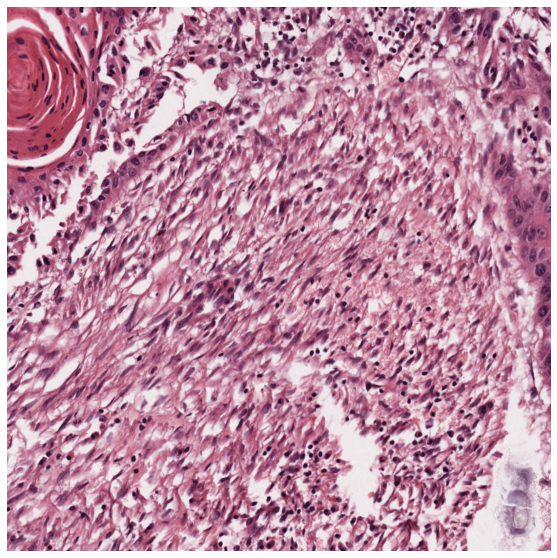

In [ ]:
img_f = fnames[287]
img = open_image(img_f)
img.show(figsize=(10,10))

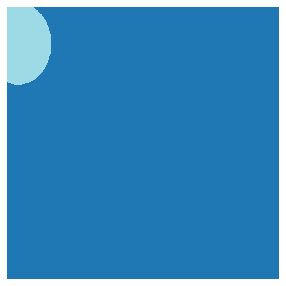

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([1024, 1024]), tensor([[[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [ ]:
codes = np.array(['Background','Keratin_Pearl'], dtype='<U17'); codes

array(['Background', 'Keratin_Pearl'], dtype='<U17')

##Creating ImageDataBunch

In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=2
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=2, have 15068MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.15)
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(),size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

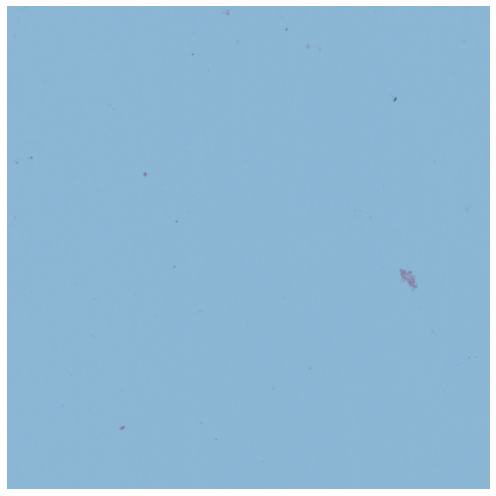

In [ ]:
data.show_batch(1, figsize=(10,7))

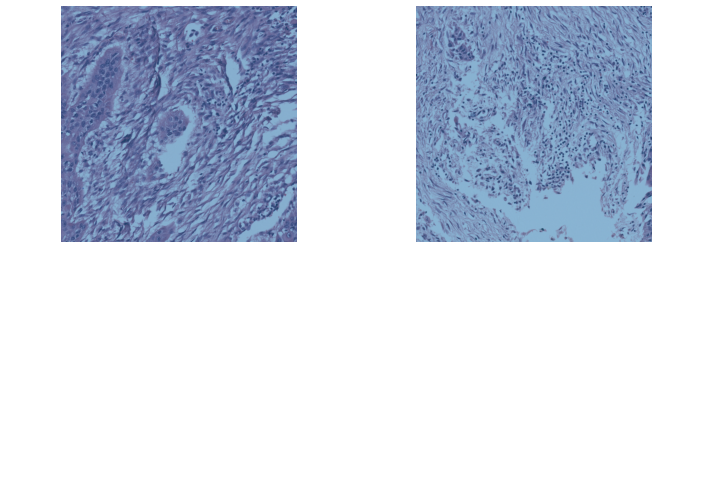

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
#name2id={'Background': 215, 'Keratin_Pearl': 30}
void_code = name2id['Background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

{'Background': 0, 'Keratin_Pearl': 1}


In [ ]:
metrics=acc_camvid
# metrics=accuracy

##UNet Learner

In [ ]:
wd=1e-2 #weight decay

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=[dice,fbeta], wd=wd)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=2e-4

In [ ]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

In [ ]:
#learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(ds_type=DatasetType.Train, rows=2, figsize=(15,15))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lrs = slice(lr/40,lr/4) # learning rate slicing

In [ ]:
learn.fit_one_cycle(35, lrs, pct_start=0.8)

In [ ]:
#learn.save('stage-2');

In [ ]:
learn.export('/content/drive/My Drive/Datasets/WSI/01-stage-2.pkl')

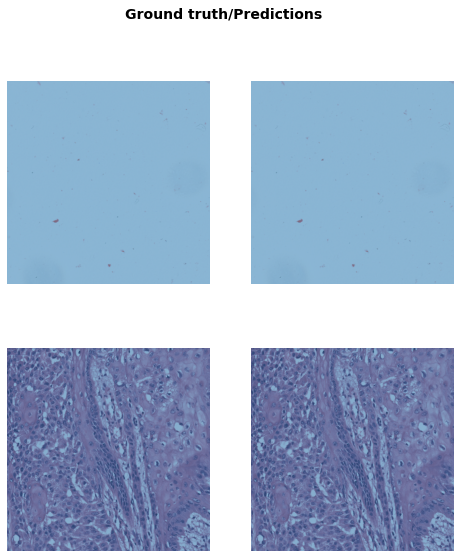

In [ ]:
learn.load('stage-2')
learn.show_results(rows=5, figsize=(8,9))

In [ ]:
#learn.fit_one_cycle(1, lrs, pct_start=0.8)

##Predictions on Validation Algorithm

In [ ]:
names_valid = data.valid_ds.items
len(names_valid)

In [ ]:
randomSamples=np.random.randint(0,len(names_valid)-1,(20))

In [ ]:
for i in randomSamples:
    p = learn.predict(data.valid_ds.x[i])
    p[0].save('/content/drive/My Drive/Datasets/WSI/predictions_keratin_pearl/' + names_valid[i].stem + '.png')

In [ ]:
path_preds=Path('/content/drive/My Drive/Datasets/WSI/predictions_keratin_pearl/').ls()

Loading Predictions from Directory

In [ ]:
for file in path_preds:
  open_mask(file).show(title=f'prediction{file.stem}')
  open_mask(get_y_fn(file)).show(title=f'groundTruth{file.stem}')
  

#Results on Test Set

##Downloading Test Set

In [ ]:
learn.load('stage-2');

In [ ]:
test_files=get_image_files('/content/drive/My Drive/Datasets/WSI/Data_20201001/test/test2/')
test_mask_files=get_image_files('/content/drive/My Drive/Datasets/WSI/Data_20201001/test/test2_masks/')

In [ ]:
def dice_loss(target, pred):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.reshape(num, -1).float()  # Flatten
    m2 = target.reshape(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

In [ ]:
test_y_fn=lambda x: f'/content/drive/My Drive/Datasets/WSI/Data_20201001/test/test2_masks/{x.stem}.jpg'

In [ ]:
testSet = (SegmentationItemList.from_folder('/content/drive/My Drive/Datasets/WSI/Data_20201001/test/test2/')
       .split_by_rand_pct(0.0)
       .label_from_func(test_y_fn, classes=codes))

In [ ]:
testData = (testSet.transform(get_transforms(False,False,0,0,0,0,0,0),size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

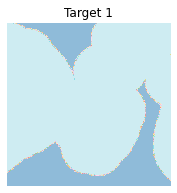

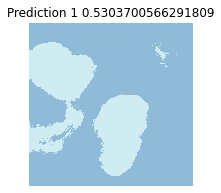

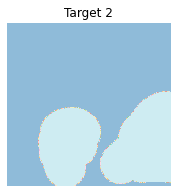

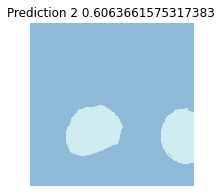

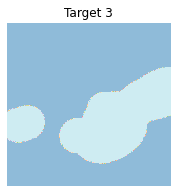

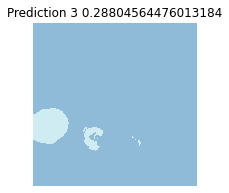

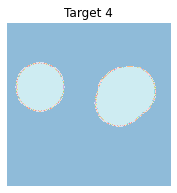

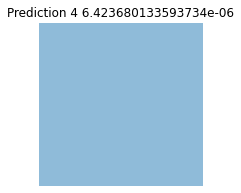

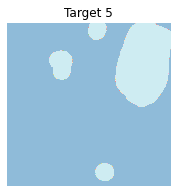

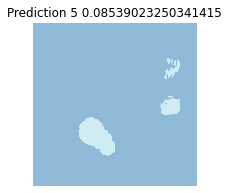

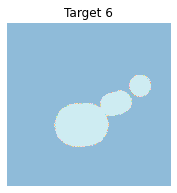

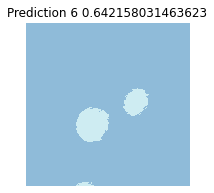

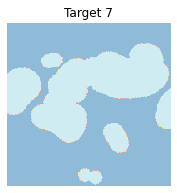

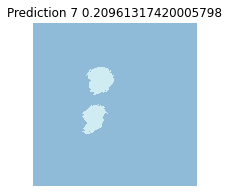

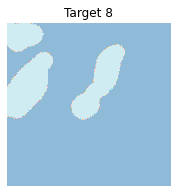

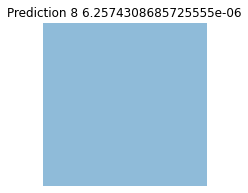

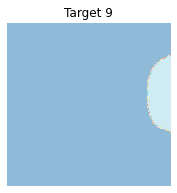

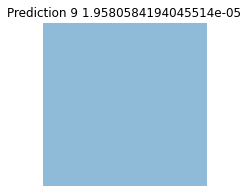

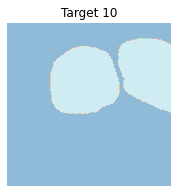

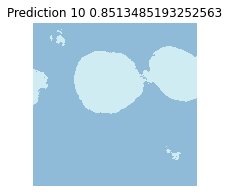

In [ ]:
count=1
dice_total=[]
for items in testData.train_ds:
  pred=learn.predict(items[0])[0]
  target=items[1]
  dice=dice_loss(target.data//255,pred.data)
  dice_total.append(dice.item())
  target.show(title=f'Target {count}')
  pred.show(title=f'Prediction {count} {dice}')
  count+=1

In [4]:
(0.53+0.6+0.28+6.42e-6+0.0853+0.64+0.21+6.257e-6+1.95e-05+0.85)/10

0.3195332177

NameError: ignored